
# FREE-ENERGY PRINCIPLE (FEP) TUTORIAL 2
## Predictive processing with Deep Active Inference
**Author: [Pablo Lanillos](https://www.ru.nl/personen/lanillos-p/).** Donders Institute for Brain, Cognition and Behaviour. Radboud University. The Netherlands.

<font color='green'>**Difficulty: medium**</font>

This tutorial is based on the Pixel Active Inference algorithm from:

- Sancaktar, Cansu, van Gerven, Marcel and Lanillos, Pablo (2020). End-to-end pixel-based deep active inference for body perception and action. IEEE International Conference on Developmental Learning and Epigenetic Robotics. 
    
    Paper: https://arxiv.org/abs/2001.05847 | code: https://github.com/cansu97/PixelAI

Further explanation of the algorithm can be found in this blog entry: https://msrmblog.github.io/is-this-my-body-2/

Version note: MINST database



## Overview

In this example we will implement the predictive procesing under the Free-energy Principle using raw images

1. Explanation of the problem and the model  
2. Initializating the variables and preparing the database
3. Computational model (autoencoder, predictive processing)   
4. Experiment

## 1. Explanation of the problem and the model

We will desing a predictive processing algorithm using raw images as input. As visual input we will use the MINST database, composed by handwritten numbers. The idea is as follows. The artificial agent has learnt to encode and decode the representation of a digit. This is, that it has a generative model of the world, thus it can predict the visual input depending of the internal variables (latent space).

**Perception:** We model perception by optimizing the variational negative free energy under the laplace approximation.


**Model architecture**
We use the decoder to compute the prediction terms needed for the FEP update equation and the backward pass to compute the needed change to minimize the free enegy. The differential equation that we solve is as follows:

$\partial \mu = \partial_\mu e_v^T \Sigma^{-1} e_v$

where $\partial_\mu$ is the partial derivative with respect to the latant variable, $e_v$ is the visual prediction error computed as the sensory imput $s$ minus the predicted value from the decoder $g(\mu)$, thus $e_v = (s-g(\mu))$. Finally $\Sigma^{-1}$ is the variance of the generative process related to the visual input. It modulates the relevance of the sensory signal to infer the environment state. In this case we only have one modality so it weights how fast the error changes the internal state. The figure below describes the algorithm architecture:

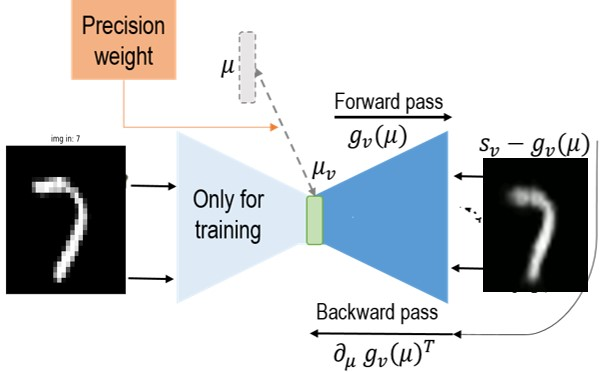


# Experiment

The experiment is as follows (see figure below): the agent has a prior of a digit (encoded as the initialization of the latent space) but then we set the visual input as another digit. The system will update the latent space until the internal representation and the sensory input matches, so the prediction error is minimized. Thus, the belief is updated to fit the visual information.

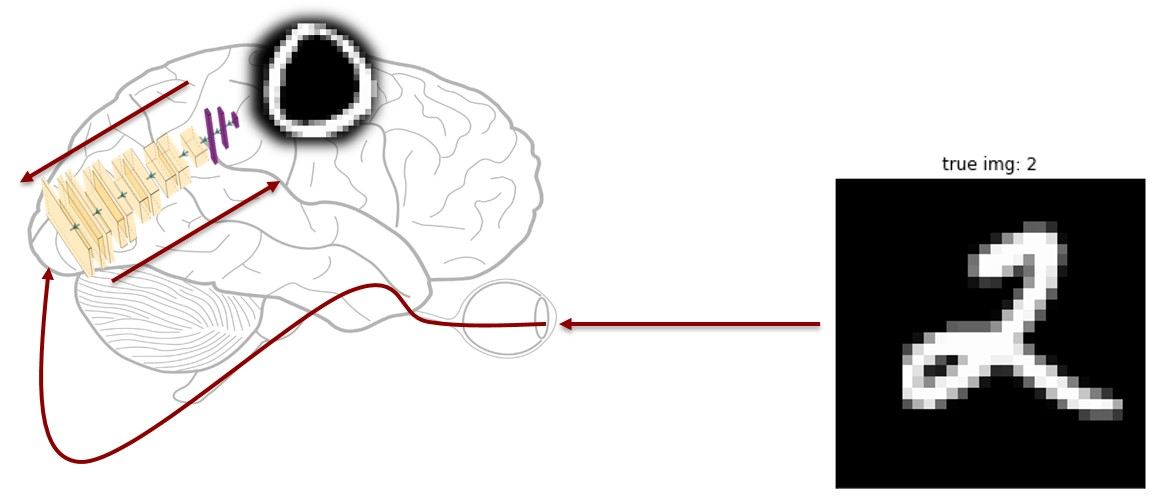

For instance, we initialize the latent state with the representation of 7 using the decoder function, then we us a 2 as visual input:


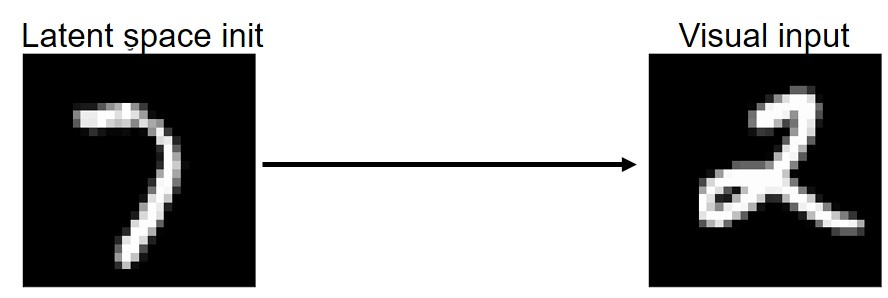


When we execute the algorithm we should observe the following evolution of the predicted number:

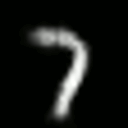

## 2. Initialization and database

In [6]:
'''
Import libraries
'''
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from torch.optim.lr_scheduler import StepLR, ExponentialLR

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys

In [9]:
'''
Database preparation
'''

# Training hyper parameters
batch_size = 128
learning_rate = 1e-3

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# write the database to your data
dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

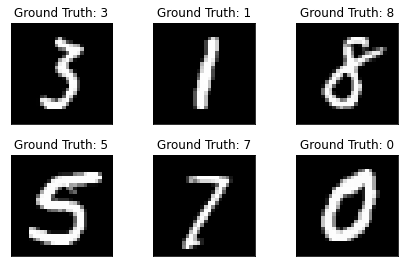

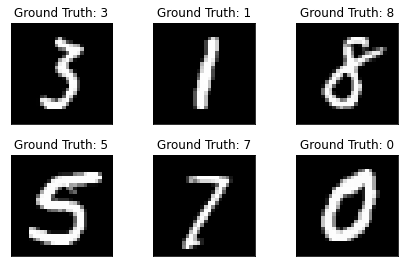

In [29]:
'''
Visualize training database
'''
examples = enumerate(dataloader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## 3. Computational model

### 3. 1 Autoencoder training

In [2]:
'''
Autoencoder implementation
''' 
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)  # b, 8, 2, 2 -> b, 8, 1, 1
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=3),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=2, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 5, 5, stride=2, padding=1),  # b, 1, 28, 28
            nn.ReLU(True),
            nn.ConvTranspose2d(5, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
      
    def train_net(self, Data, max_epochs=100):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        criterion = nn.MSELoss()

        epoch_loss=[]
        cur_batch_loss=[]
        batch_loss=[]

        for epoch in range(max_epochs):        
          for data in dataloader:
              img, label = data
              input_x= Variable(img)
              #Forward
              output_y = self(input_x)
              loss = criterion(output_y, input_x)
              # Backward pass
              optimizer.zero_grad()  # zero the gradient buffers
              loss.backward()
              optimizer.step()  # Does the update
              
          # ===================log========================
          print('epoch [{}/{}], loss:{:.4f}'
                .format(epoch+1, max_epochs, loss.item()))
          if epoch % 10 == 0:
              pic = to_img(output_y.cpu().data)
              fig = plt.figure()
              for i in range(6):
                plt.subplot(2,3,i+1)
                plt.tight_layout()
                plt.imshow(pic[i][0], cmap='gray', interpolation='none')
                plt.title("Ground Truth: {}".format(label[i]))
                plt.xticks([])
                plt.yticks([])
              plt.show()
          
          cur_batch_loss=np.append(cur_batch_loss, [loss.item()])
          batch_loss=np.append(batch_loss, [loss.item()])

In [ ]:
# train autoencoder (You do not need to run it again if it is already trained)
model = AutoEncoder()
model.train_net(dataloader,max_epochs=20)

In [ ]:
# save model. This model will be loaded in the class
torch.save(model.state_dict(), './data/conv_autoencoder.pth')

### 3.2 Deep Predictive Processing based on the Pixel AI algorithm.
Tasks:
1. Implement the function dF_dmu_visual(self) inside the pixelPP class following the instructions
2. Study the predictive processing function pp(self)

In [10]:
'''
Pixel Predictive Processing implementation
'''
class pixelPP():
    def __init__(self,iterations=100):
      self.width = 28
      self.height = 28
      self.crop=True
      self.dt = 0.5
      self.sigma_v=1e1 # visual inverse precision
      self.iterations = iterations # optimization iterations
      # Load network for the visual forward model
      self.network = AutoEncoder()
      self.network.load_state_dict(torch.load('./data/conv_autoencoder.pth'))
      self.network.eval()

      self.mu = torch.FloatTensor()
      self.sv = torch.FloatTensor()
      
    #### Helper functions
    def ready(self):
      return len(self.mu) and len(self.s_v)

    def img_show(self, x, label, text):
      fig = plt.figure()
      plt.tight_layout()
      plt.imshow(x[0], cmap='gray', interpolation='none')
      plt.title(text +": {}".format(label))
      plt.xticks([])
      plt.yticks([])
      plt.show()

    def set_latent(self, img, label):
      imgin = Variable(torch.unsqueeze(img,0))
      self.label_in = label
      self.mu = self.network.encoder(imgin) # latent initialization
      self.e_mu = torch.zeros(self.mu.shape) # error init       
      # prediction for debugging
      self.gv = self.network.decoder(Variable(self.mu, requires_grad=False))
      #Debug variables
      self.store_mu=torch.squeeze(self.mu).data.numpy()

    def set_sv(self, img, label):
      self.true_label = label
      self.s_v = img
      self.true_mu = self.network.encoder(Variable(torch.unsqueeze(img,0)))
      self.e_v = torch.zeros(img.shape) # error init
    ####


    #### TODO PREDICTIVE PROCESSING (FEP) 
    def dF_dmu_visual(self):
        input = Variable(self.mu, requires_grad=True) # latent space
        
        ## 1. prediction 
        # Compute the visual prediction using the decoder and store in self.gv
        self.gv = self.network.decoder(input)

        ## 2. prediction error 
        # compute the prediction error between the visual input s_v and the previously computed visual prediction
        self.e_v=(self.s_v - self.gv)        

        ## 3. compute the free energy derivative using the neural network backward pass
        # Reminder: mu_dot = \partial_mu gv(\mu)^T sigma_v^-1 * visual_error
        # but here we must use the network to compute it using the chain rule. See below

        # 3.1 compute dF_dg
        dF_dg=(1/self.sigma_v)*self.e_v

        # Set the gradient to zero before the backward pass to make sure there is no accumulation from previous backward passes
        input.grad=torch.zeros(input.size())
        # 3.2 compute the backward pass of the network using a torch array with the size and values of dF_dg. Use retain_graph= true
        self.gv.backward(torch.ones(self.gv.shape)*dF_dg,retain_graph=True)
        
        # if you want to print the gradient print("Direct output of gradient:", torch.squeeze(input.grad)) # this will give non-zero value

        ## 4. Assign to the latent space its new value stored in input.grad
        mu_dot= input.grad # This I just put it to make the rest of the code working.               
        return mu_dot #This is a (1x8x1x1) torch vector - 1 sample, 8 dimensions latent space

    
    # Predictive processing
    def pp(self):
      if not self.ready():
        print("class not properly initialized")
        return
      else:
        
        # free energy minimization
        mu_dot = self.dF_dmu_visual()
        # integration step
        self.mu = torch.add(self.mu, mu_dot, alpha=self.dt) # mu = mu + dt*mu_dot    
        # this is just for visualization          
        self.e_mu = torch.squeeze(self.mu-self.true_mu) 
        #log vars
        self.store_mu=np.vstack((self.store_mu,torch.squeeze(self.mu).data.numpy()))

    def run(self):
      # Run predictive processing
      for i in range(self.iterations):
        ## debug
        if i % 10 == 0:
          pic = to_img(model.gv.data)          
          fig = plt.figure()
          plt.tight_layout()
          plt.imshow(pic[0][0], cmap='gray', interpolation='none')
          plt.title("Ground Truth: {}->{}".format(model.label_in, model.true_label))
          plt.xticks([])
          plt.yticks([])
          plt.show()
        # execute predictive processing iteration   
        model.pp()

## 4. Experiment

Once you properly implemented the code you can run the experiment. If you run the model without implementing the previous section, latent space will not be affected, thus outputing wrong values.

In [16]:
# Load database
dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [17]:
## Get the first example
examples = enumerate(dataloader) #data iterator
#compare all data against autoencoder
batch_ids, (imgs, labels) = next(examples)

You shoud see that the prediction turns into the selected visual input. The leyend is as follows:

**Ground Truth: 3->2** means that the latent is initialized to 3 and the visual input is 2.

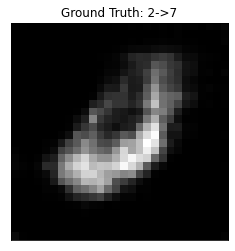

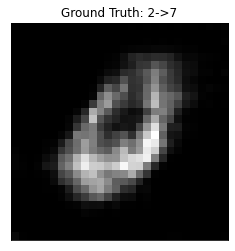

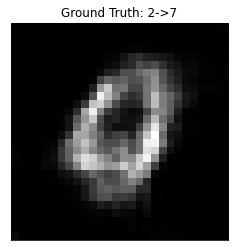

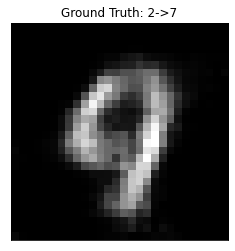

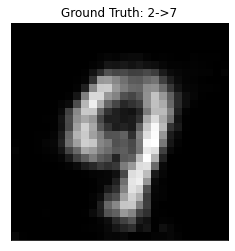

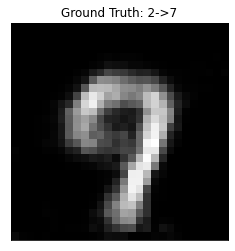

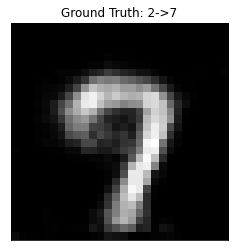

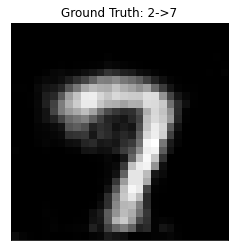

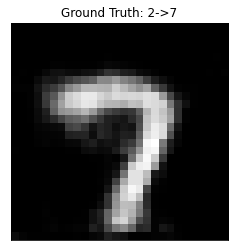

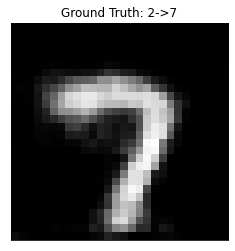

In [18]:
# Execute model
model = pixelPP(iterations=100) # Create computational model
model.set_latent(imgs[0], labels[0])  # Initialize latent space (state) with the first image    
model.set_sv(imgs[1],labels[1]) # Show the model a different image. (Visual input)
model.run() # run the predictive processing algorithm

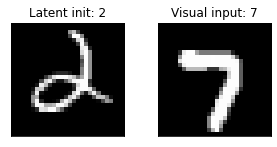

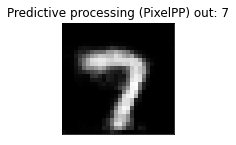

In [19]:
# Visualize the latent space dynamics and the image results
pic_ai = to_img(model.gv.data)
pic_latent = to_img(imgs[0])
pic_sv = to_img(imgs[1])
fig = plt.figure()
plt.subplot(1,3,1)
plt.tight_layout()
plt.imshow(pic_latent[0][0], cmap='gray', interpolation='none')
plt.title("Latent init: {}".format(labels[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.tight_layout()
plt.imshow(pic_sv[0][0], cmap='gray', interpolation='none')
plt.title("Visual input: {}".format(labels[1]))
plt.xticks([])
plt.yticks([])
plt.show()
plt.subplot(1,3,3)
plt.tight_layout()
plt.imshow(pic_ai[0][0], cmap='gray', interpolation='none')
plt.title("Predictive processing (PixelPP) out: {}".format(labels[1]))
plt.xticks([])
plt.yticks([])
plt.show()


The following plot describe the evolution of the latent space variables. You should see a change and then stabilization of the values.

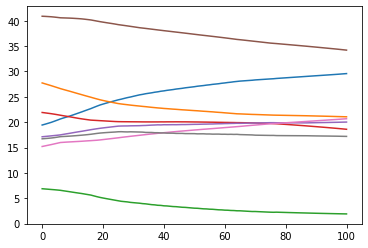

In [15]:
# show latent space evolution
fig = plt.figure()
plt.plot(model.store_mu)
plt.show()